<a href="https://colab.research.google.com/github/aritanaoya/howling_canceler/blob/master/%E3%83%8F%E3%82%A6%E3%83%AA%E3%83%B3%E3%82%AF%E3%82%99%E3%82%AD%E3%83%A3%E3%83%B3%E3%82%BB%E3%83%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, shutil

os.getcwd()
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 4.8MB/s 


In [0]:
id = '1YSYyEG-rMlpJow66JwdvgFb1nwR01bIg'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('sounds.zip')

In [5]:
!unzip sounds.zip
!ls
!pip install librosa==0.7

Archive:  sounds.zip
  inflating: sound/ford8k.wav        
  inflating: sound/ford8k_10s.wav    
  inflating: sound/ford8k_10s_howling1500out.wav  
  inflating: sound/ford8k_10s_howling2000out.wav  
  inflating: sound/ford8k_20s.wav    
  inflating: sound/ford8k_20s_howling1500out.wav  
  inflating: sound/ford8k_20s_howling2000out.wav  
  inflating: sound/ford8k_30s.wav    
  inflating: sound/ford8k_30s_howling1500out.wav  
  inflating: sound/ford8k_30s_howling2000out.wav  
  inflating: sound/ford8k_40s.wav    
  inflating: sound/ford8k_40s_howling1500out.wav  
  inflating: sound/ford8k_40s_howling2000out.wav  
  inflating: sound/ford8k_50s.wav    
  inflating: sound/ford8k_50s_howling1500out.wav  
  inflating: sound/ford8k_50s_howling2000out.wav  
adc.json  sample_data  sound  sounds.zip
     |████████████████████████████████| 1.6MB 5.0MB/s 
  Created wheel for librosa: filename=librosa-0.7.0-cp36-none-any.whl size=1598345 sha256=df9a3730076dde261a4fa27b30e1be63bff1d3ae1fb49b51c12260b

In [6]:
import os, shutil
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import numpy as np

Using TensorFlow backend.


In [7]:
!ls
!pwd

adc.json  sample_data  sound  sounds.zip
/content


In [0]:
batch_size = 32
num_classes = 10
epochs = 100
saveDir = "/content/howling_canceller"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [48]:
#音声の読み込み
import librosa
import librosa.core as lc  
import numpy as np  
import scipy 
import IPython.display as ipd
import os
import matplotlib.pyplot as plt
import librosa.display



def load_sound_files(parent_dir, file_paths):
    raw_sounds = []
    
    for fp in file_paths:
        y,sr = librosa.load(parent_dir + fp)
        raw_sounds.append(y)
    return raw_sounds
   
correct_sound_file_paths = ["ford8k_10s.wav","ford8k_20s.wav"]
howling_sound_file_paths = ["ford8k_10s_howling1500out.wav","ford8k_20s_howling1500out.wav"]
parent_dir = '/content/sound/'
correct_sounds=[]
howling_sounds=[]
correct_sounds= load_sound_files(parent_dir,correct_sound_file_paths)
howling_sounds= load_sound_files(parent_dir,howling_sound_file_paths)

print((correct_sounds))

[array([0.01172579, 0.02113312, 0.02969441, ..., 0.3400613 , 0.28071502,
       0.16439699], dtype=float32), array([ 0.20006423,  0.18865108,  0.19383042, ...,  0.01141573,
        0.0019252 , -0.00200214], dtype=float32)]


In [78]:

# Get the power spectrogram
def cal_power_spectrogram(y):
  x=[]
  for i in  range(len(y)):
    x.append(np.abs(librosa.stft(y[i]))**2)
  return x

powerspec_correct_sounds=[]
powerspec_howling_sounds=[]
powerspec_correct_sounds = cal_power_spectrogram(correct_sounds)
print(powerspec_correct_sounds[0].shape)
powerspec_howling_sounds= cal_power_spectrogram(howling_sounds)


(1025, 431)


In [92]:
(x_train, x_train_noisy) = (powerspec_correct_sounds, powerspec_howling_sounds)


#print(powerspec_howling_sounds[1].shape)

#print(powerspec_howling_sounds[0])

xtrain = powerspec_howling_sounds[0].reshape(((1025,431,3)))
print(xtrain.shape)                                            

ValueError: ignored

In [74]:
#griffin_limの確認（位相復元）
y=lc.griffinlim(powerspec_correct_sounds[1])
print(y.shape)
s=howling_sounds[1]
ipd.Audio(data=y,rate=22400)


(220160,)


IndexError: ignored

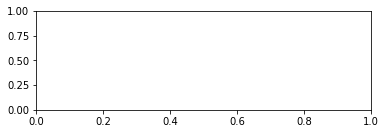

In [36]:
#音声プロット
#パワースペクトルと対数パワースペクトル
def plt_power_spec(S,sr):
  plt.figure()
  plt.subplot(2, 1, 1)
  librosa.display.specshow(S, sr=sr, y_axis='log')
  plt.colorbar()
  plt.title('Power spectrogram')
  plt.subplot(2, 1, 2)
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         sr=sr, y_axis='log', x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Log-Power spectrogram')
  plt.tight_layout()
  plt.show()

plt_power_spec(powerspec_howling_sounds[0],22400)

In [0]:
print(S.shape)

(1025, 157)


In [80]:
#モデル構築

input_img = Input(shape=(1024, 431,))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

W0828 05:04:25.229011 140466079913856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 05:04:25.270122 140466079913856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 05:04:25.277217 140466079913856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 05:04:25.327521 140466079913856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0828 05:04:25.328984 1404660799

In [81]:
#モデルのコンパイル
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

W0828 05:04:34.138710 140466079913856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 05:04:34.169918 140466079913856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024, 431, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1024, 431, 32)     320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 431, 32)     128       
_________________________________________________________________
activation_1 (Activation)    (None, 1024, 431, 32)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 512, 216, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 216, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 216, 32)      128       
__________

In [86]:
history = model.fit(x_train_noisy[0], x_train[0],
                    batch_size=batch_size,
                    epochs=epochs,
                   )

ValueError: ignored